In [19]:
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns
import pandas as pd

BOARD_SIZE = 100

#### Create board layout


In [20]:
def create_snakes_and_ladders(board_size, num_snakes, num_ladders):
    """
    Generates random positions for snakes and ladders,
    prioritizing board connectivity to avoid singular matrices.
    """
    while True:  # Regenerate until valid board
        snakes, ladders = _generate_snakes_and_ladders_once(board_size, num_snakes, num_ladders)

        # Check connectivity by verifying no zero rows in Q matrix
        transition_matrix = create_transition_matrix(board_size, snakes, ladders)
        excluded_tiles = set(snakes.keys()) | set(ladders.keys())
        valid_states = [state for state in range(board_size + 1) if state not in excluded_tiles]
        n = len(valid_states)
        Q_check = transition_matrix.iloc[:n, :n].copy()

        has_zero_row = False
        for index, row in Q_check.iterrows():
            if all(row == 0):
                has_zero_row = True
                break

        if not has_zero_row:
            print(f"Valid board generated after regeneration attempts.")
            return snakes, ladders
        else:
            print("Board layout with isolated states. Regenerating...")


def _generate_snakes_and_ladders_once(board_size, num_snakes, num_ladders):
    """
    Helper function to generate snakes and ladders with connectivity heuristics.
    """
    snakes = {}
    ladders = {}
    used_tiles = set()

    def generate_endpoints(entity_type, used_tiles):
        attempts = 0
        while attempts < 100:  # Limit attempts to prevent infinite loops in extreme cases
            attempts += 1
            if entity_type == "snake":
                start_tile = random.randint(20, board_size - 1)  # Snakes start further up
            else:  # ladder
                start_tile = random.randint(2, board_size - 30) # Ladders start lower

            if start_tile in used_tiles:
                continue

            if entity_type == "snake":
                end_tile = random.randint(1, start_tile - 20) # Snakes go down significantly
            else:  # ladder
                end_tile = random.randint(start_tile + 10, board_size - 1) # Ladders go up significantly

            if end_tile in used_tiles or end_tile == start_tile:
                continue

            valid_placement = _check_overlap(snakes, ladders, start_tile, end_tile, entity_type) # Use helper

            if valid_placement:
                used_tiles.add(start_tile)
                used_tiles.add(end_tile)
                return start_tile, end_tile
        return None, None # Return None if no valid placement found after attempts


    def _check_overlap(snakes, ladders, start_tile, end_tile, entity_type):
        """Helper function to check for overlaps (same as before)."""
        valid_placement = True
        for s_start, s_end in snakes.items():
            if start_tile == s_start or start_tile == s_end or end_tile == s_start or end_tile == s_end:
                valid_placement = False
                break
        if not valid_placement:
            return False

        for l_start, l_end in ladders.items():
            if start_tile == l_start or start_tile == l_end or end_tile == l_start or end_tile == l_end:
                valid_placement = False
                break
        return valid_placement


    # Generate Snakes - with retry mechanism if placement fails
    snakes_placed = 0
    for _ in range(num_snakes * 2): # Try placing snakes more times than needed
        if snakes_placed >= num_snakes:
            break # Stop if enough snakes placed
        start, end = generate_endpoints("snake", used_tiles)
        if start is not None: # Check if valid placement was found
            snakes[start] = end
            snakes_placed += 1

    # Generate Ladders - with retry mechanism
    ladders_placed = 0
    for _ in range(num_ladders * 2): # Try placing ladders more times than needed
        if ladders_placed >= num_ladders:
            break # Stop if enough ladders placed
        start, end = generate_endpoints("ladder", used_tiles)
        if start is not None: # Check if valid placement was found
            ladders[start] = end
            ladders_placed += 1


    return snakes, ladders


#### Simulate the Game


In [21]:
def simulate_game(board_size, snakes, ladders, record_positions=False, record_entity_triggers=False):
    """
    Simulates a single game of Snakes and Ladders.
    
    Args:
        board_size (int): Size of the board
        snakes (dict): Dictionary of snake positions
        ladders (dict): Dictionary of ladder positions
        record_positions (bool): Whether to record all positions visited
        record_entity_triggers (bool): Whether to record snake/ladder triggers
        
    Returns:
        tuple: (turns taken, positions visited, entity triggers)
    """
    position = 0
    turns = 0
    positions_visited = [] if record_positions else None
    entity_triggers = [] if record_entity_triggers else None

    if record_positions:
        positions_visited.append(position)

    while position < board_size:
        roll = random.randint(1, 6)
        new_position = position + roll

        if new_position > board_size:
            new_position = board_size - (new_position - board_size)

        position = new_position
        turns += 1

        if record_positions:
            positions_visited.append(position)

        if position in snakes:
            if record_entity_triggers:
                entity_triggers.append(position)
            position = snakes[position]
            if record_positions:
                positions_visited.append(position)
        elif position in ladders:
            if record_entity_triggers:
                entity_triggers.append(position)
            position = ladders[position]
            if record_positions:
                positions_visited.append(position)

    return turns, positions_visited, entity_triggers

#### Create Markov Process


In [22]:
def create_transition_matrix(board_size, snakes, ladders):
    """
    Creates a transition matrix for the Snakes and Ladders Markov model,
    EXCLUDING snake heads and ladder bases as states.

    Args:
        board_size (int): Size of the board
        snakes (dict): Dictionary of snake positions (head: tail)
        ladders (dict): Dictionary of ladder positions (base: top)

    Returns:
        pandas.DataFrame: Transition matrix (DataFrame)
    """
    # Identify snake heads and ladder bases to exclude as states
    excluded_tiles = set(snakes.keys()) | set(ladders.keys())
    valid_states = [state for state in range(board_size + 1) if state not in excluded_tiles]
    num_states = len(valid_states)

    transition_matrix = pd.DataFrame(0.0, index=valid_states, columns=valid_states)

    state_to_index = {state: index for index, state in enumerate(valid_states)} # Map state to index

    for current_tile in valid_states:
        if current_tile == board_size: # Absorbing state
            transition_matrix.loc[current_tile, current_tile] = 1.0
            continue

        probabilities = [0.0] * num_states # Initialize probabilities for valid states

        for roll in range(1, 7):
            next_position_tentative = current_tile + roll

            if next_position_tentative > board_size:
                next_position_tentative = board_size - (next_position_tentative - board_size) # Bounce back

            next_position = next_position_tentative # Initialize assuming no snake/ladder

            # Check for snakes and ladders at the *tentative* next position
            if next_position_tentative in snakes:
                next_position = snakes[next_position_tentative] # Move to snake tail
            elif next_position_tentative in ladders:
                next_position = ladders[next_position_tentative] # Move to ladder top

            # Ensure next_position is a valid state (not a snake head or ladder base)
            while next_position in excluded_tiles:
                if next_position in snakes:
                    next_position = snakes[next_position] # Chain snake
                elif next_position in ladders:
                    next_position = ladders[next_position] # Chain ladder
                else: # Should not happen in a well-formed board, but as a safeguard
                    break # Break out if stuck in an infinite loop

            if next_position in valid_states:
                next_state_index = state_to_index[next_position] # Get index in reduced state space
                probabilities[next_state_index] += 1/6.0
            elif next_position == board_size: # Handle reaching the goal (absorbing state)
                next_state_index = state_to_index[board_size]
                probabilities[next_state_index] += 1/6.0


        # Assign probabilities to the transition matrix row
        for next_state_index, prob in enumerate(probabilities):
            next_state = valid_states[next_state_index]
            transition_matrix.loc[current_tile, next_state] = prob


    return transition_matrix

def calculate_expected_turns_markov(transition_matrix, board_size, snakes, ladders):
    # Get valid states (excluding snake heads/ladder bases AND the absorbing state)
    excluded_tiles = set(snakes.keys()) | set(ladders.keys()) | {board_size}
    valid_states = [state for state in range(board_size) if state not in excluded_tiles]
    n = len(valid_states)
    
    # Extract Q matrix (only transient states)
    Q = transition_matrix.loc[valid_states, valid_states].copy()
    I = pd.DataFrame(np.identity(n), index=valid_states, columns=valid_states)
    
    try:
        N = np.linalg.inv(I - Q)
        ones = np.ones(n)
        expected_turns = N.dot(ones)
        return expected_turns[0]  # Return the expected turns from state 0
    except np.linalg.LinAlgError as e:
        print("Matrix inversion failed. Check transition matrix structure.")
        raise e
    
def calculate_steady_state_distribution(transition_matrix, board_size, snakes, ladders, initial_state=0, num_iterations=500): # Added snakes, ladders
    """
    Calculates the steady-state distribution of tile occupation probabilities,
    ADJUSTED FOR REDUCED STATE SPACE.
    """
    # Get valid states - IMPORTANT: Re-calculate valid states to be consistent with transition_matrix
    excluded_tiles = set(snakes.keys()) | set(ladders.keys())
    valid_states = [state for state in range(board_size + 1) if state not in excluded_tiles]
    num_states = len(valid_states) # Recalculate num_states based on valid_states

    state_distribution = pd.Series([0.0] * num_states, index=valid_states) # Use valid_states as index
    state_distribution[initial_state] = 1.0

    # Ensure state_distribution index matches transition_matrix columns - EXPLICIT CHECK
    state_distribution.index = transition_matrix.columns # Force index alignment (although now it should match already)

    # Debugging Prints:
    print("\n--- Debugging Information (calculate_steady_state_distribution) ---")
    print("Shape of state_distribution (should be num_states):", state_distribution.shape)
    print("Shape of transition_matrix (should be num_states x num_states):", transition_matrix.shape)
    print("\nstate_distribution Index (first 10):", state_distribution.index[:10]) # Print first 10 indices
    print("\ntransition_matrix Columns Index (first 10):", transition_matrix.columns[:10]) # Print first 10 column indices
    print("\nstate_distribution dtype:", state_distribution.dtype)
    print("\ntransition_matrix dtypes (first 5 columns):", transition_matrix.dtypes.head())
    print("--- End Debugging Information ---")


    for _ in range(num_iterations):
        # state_distribution = state_distribution.dot(transition_matrix) # Original dot product
        state_distribution = state_distribution @ transition_matrix # Try @ operator - ALTERNATIVE DOT PRODUCT

    return state_distribution

def simulate_game_markov_distribution(transition_matrix, num_games, board_size):
    """
    Simulates games directly from the Markov transition matrix to generate turn distribution.

    Args:
        transition_matrix (pd.DataFrame): Markov transition matrix.
        num_games (int): Number of games to simulate.
        board_size (int): Size of the board.

    Returns:
        list: List of turn counts for simulated games.
    """

    turn_counts_markov = []
    start_state_index = 0 # Assuming starting from state 0

    for _ in range(num_games):
        current_state = start_state_index
        turns = 0
        while current_state < board_size: # While not in absorbing state (state 100)
            probabilities = transition_matrix.loc[current_state].values # Get transition probabilities for current state
            next_state = random.choices(transition_matrix.columns, weights=probabilities, k=1)[0] # Probabilistic transition
            current_state = next_state
            turns += 1
        turn_counts_markov.append(turns)
    return turn_counts_markov

#### Create Plots


In [23]:
def create_labeled_board_representation(board_size, snakes, ladders):
    """
    Creates a NumPy array representation of a Snakes and Ladders board with labels for sns.heatmap.

    Args:
        board_size (int): Size of the board
        snakes (dict): Dictionary of snake positions
        ladders (dict): Dictionary of ladder positions

    Returns:
        numpy.ndarray: 10x10 NumPy array of strings representing tile labels
    """
    grid = np.empty((10, 10), dtype=object)  # NumPy array of objects to hold strings

    for tile in range(1, board_size + 1):
        row = (tile - 1) // 10
        col = (tile - 1) % 10
        if row % 2 == 1:
            col = 9 - col

        tile_label = str(tile)

        if tile in snakes:
            tile_label = f'S{tile}→{snakes[tile]}'
        elif tile in ladders:
            tile_label = f'L{tile}→{ladders[tile]}'

        grid[9 - row, col] = tile_label

    return grid


def plot_board_heatmap_representation(board_size, snakes, ladders):
    """
    Plots a Snakes and Ladders board representation using sns.heatmap with labels.

    Args:
        board_size (int): Size of the board
        snakes (dict): Dictionary of snake positions
        ladders (dict): Dictionary of ladder positions
    """
    grid_representation = create_labeled_board_representation(board_size, snakes, ladders)
    empty_board_data = np.zeros((10, 10)) # Dummy data for heatmap

    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(empty_board_data, annot=grid_representation, fmt='s', cmap='Greys', # Use 'Wistia' or 'Greys' cmap
                linewidths=1, linecolor='black', cbar=False, annot_kws={"fontsize": 9, "fontweight": "bold"}, ax=ax) # Adjust fontsize here

    ax.set_title("Snakes and Ladders Board", fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis() # Invert y-axis to match board layout

    return plt # Return plt object


# %%


In [24]:
def plot_turn_distribution(turn_counts_simulation, turn_counts_markov, num_snakes, num_ladders, num_simulations):
    """
    Plots and compares turn distributions from simulations and Markov model.
    """
    plt.figure(figsize=(10, 6))
    
    # Determine bin size
    max_turns = max(max(turn_counts_simulation), max(turn_counts_markov))
    min_turns = min(min(turn_counts_simulation), min(turn_counts_markov))

    bin_size = max(1, (max_turns - min_turns) // 20)

    # Plot histograms for both simulation and Markov data
    plt.hist(turn_counts_simulation, bins=range(min_turns, max_turns + bin_size, bin_size),
             align='left', rwidth=0.8, color='skyblue', edgecolor='black', density=True, label='Simulation')
    plt.hist(turn_counts_markov, bins=range(min_turns, max_turns + bin_size, bin_size),
             align='left', rwidth=0.8, color='coral', edgecolor='black', density=True, alpha=0.7, label='Markov Model') # Use different color, reduce alpha

    plt.xlabel("Number of Turns")
    plt.ylabel("Probability")
    plt.title(f"Comparison of Turn Distributions\n(Simulation vs. Markov Model) - ({num_snakes} Snakes, {num_ladders} Ladders, {num_simulations} Simulations)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(min_turns, max_turns + 1, bin_size*2)) # Adjusted x-ticks for better readability
    plt.legend() # Show legend to distinguish datasets
    plt.tight_layout()
    plt.show()



def plot_board_heatmap(all_positions_visited, board_size, snakes, ladders, num_simulations):
    """
    Creates a heatmap showing frequency of visits to each board position.
    """
    tile_counts = Counter()
    for positions_list in all_positions_visited:
        tile_counts.update(positions_list)

    board_grid = np.zeros((10, 10))
    for tile in range(1, board_size + 1):
        row = (tile - 1) // 10  
        col = (tile - 1) % 10
        if row % 2 == 1:
            col = 9 - col
        board_grid[9 - row, col] = tile_counts.get(tile, 0)

    plt.figure(figsize=(12, 10))
    sns.heatmap(board_grid, annot=False, fmt="d", cmap="viridis",
                linewidths=.5, cbar_kws={'label': 'Visit Frequency'})
    
    # Add snake and ladder markers
    for start, end in snakes.items():
        row = (start - 1) // 10
        col = (start - 1) % 10 if row % 2 == 0 else 9 - ((start - 1) % 10)
        plt.text(col, 9 - row, 'S', color='white', ha='center', va='center', fontsize=8)
    
    for start, end in ladders.items():
        row = (start - 1) // 10
        col = (start - 1) % 10 if row % 2 == 0 else 9 - ((start - 1) % 10)
        plt.text(col, 9 - row, 'L', color='white', ha='center', va='center', fontsize=8)

    plt.title(f"Visit Frequency Heatmap\n({num_simulations} Simulations)")
    plt.xticks(np.arange(0, 10, 1), labels=[f'{i*10+1}-{(i+1)*10}' for i in range(10)])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
def plot_entity_trigger_heatmap(all_entity_triggers, board_size, snakes, ladders, num_simulations):
    """
    Creates a heatmap showing frequency of snake and ladder triggers.
    Fixed to show correct start→end labels for snakes and ladders.
    """
    tile_counts = Counter()
    for triggers in all_entity_triggers:
        tile_counts.update(triggers)

    board_grid = np.zeros((10, 10))
    
    # Fill the grid with trigger counts
    for tile in range(1, board_size + 1):
        row = (tile - 1) // 10
        col = (tile - 1) % 10
        if row % 2 == 1:
            col = 9 - col
        board_grid[9 - row, col] = tile_counts.get(tile, 0)

    plt.figure(figsize=(12, 10))
    
    # Create heatmap with white for zero values
    sns.heatmap(board_grid, annot=True, fmt=".0f", cmap="YlOrRd",
                linewidths=.5, cbar_kws={'label': 'Trigger Frequency'},
                mask=(board_grid == 0))
    
    # Add a background color for cells with zero values
    plt.gca().patch.set_facecolor('lightgray')
    
    # Add markers for snakes and ladders with correct start→end format
    for start, end in snakes.items():
        row = (start - 1) // 10
        col = (start - 1) % 10 if row % 2 == 0 else 9 - ((start - 1) % 10)
        plt.text(col, 9 - row, f'S{start}→{end}', color='darkblue', 
                ha='center', va='center', fontsize=8, fontweight='bold')
    
    for start, end in ladders.items():
        row = (start - 1) // 10
        col = (start - 1) % 10 if row % 2 == 0 else 9 - ((start - 1) % 10)
        plt.text(col, 9 - row, f'L{start}→{end}', color='darkgreen', 
                ha='center', va='center', fontsize=8, fontweight='bold')

    plt.title(f"Snake and Ladder Trigger Frequency\n({num_simulations} Simulations)")
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_steady_state_heatmap(steady_state_distribution, board_size, snakes, ladders): # Added snakes, ladders
    """
    Generates and displays a heatmap of steady-state tile occupation probabilities,
    ADJUSTED FOR REDUCED STATE SPACE.
    """
    plt.figure(figsize=(12, 10))
    board_grid_steady_state = np.zeros((10, 10))

    # Get valid states - IMPORTANT: Use valid states from transition_matrix creation
    excluded_tiles = set(snakes.keys()) | set(ladders.keys())
    valid_states = [state for state in range(board_size + 1) if state not in excluded_tiles]

    for tile in valid_states: # Iterate over valid_states only - CORRECTED LOOP
        if tile > 0 and tile <= board_size: # Ensure tile is within board range and not state 0
            row = (tile - 1) // 10
            col = (tile - 1) % 10
            if row % 2 == 1:
                col = 9 - col
            board_grid_steady_state[9 - row, col] = steady_state_distribution[tile] # Access using 'tile' index


    sns.heatmap(board_grid_steady_state, cmap="viridis", linewidths=.5, cbar_kws={'label': 'Steady-State Probability'})
    plt.title(f"Steady-State Tile Occupation Probability Heatmap")
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

#### Main Loop


Valid board generated after regeneration attempts.

Board Configuration:
Snakes: {30: 10, 44: 8, 57: 21, 51: 12, 80: 9, 77: 5, 54: 22, 46: 23, 64: 4, 31: 11}
Ladders: {36: 70, 18: 60, 69: 79, 7: 34, 29: 72, 62: 82, 33: 55, 28: 48, 58: 75, 61: 96}


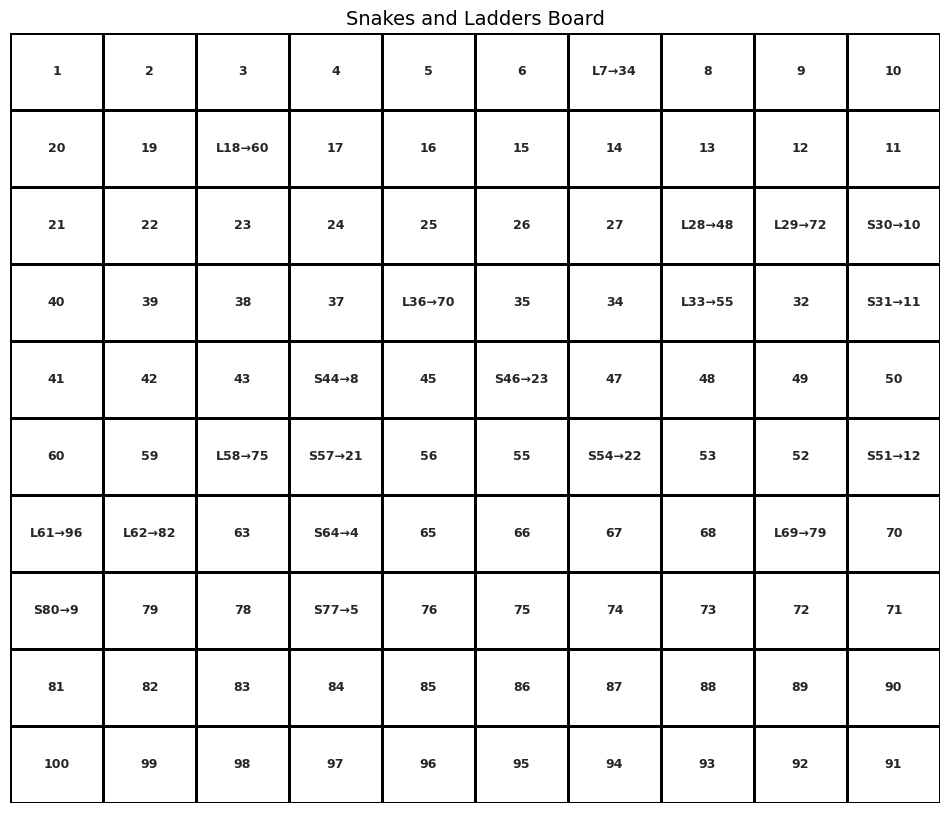


Simulation Results:
Average Turns (Simulation): 32.61
Min Turns: 5
Max Turns: 197

Markov Analysis:
Expected Turns (Markov Model): 32.27

--- Debugging Information (calculate_steady_state_distribution) ---
Shape of state_distribution (should be num_states): (81,)
Shape of transition_matrix (should be num_states x num_states): (81, 81)

state_distribution Index (first 10): Index([0, 1, 2, 3, 4, 5, 6, 8, 9, 10], dtype='int64')

transition_matrix Columns Index (first 10): Index([0, 1, 2, 3, 4, 5, 6, 8, 9, 10], dtype='int64')

state_distribution dtype: float64

transition_matrix dtypes (first 5 columns): 0    float64
1    float64
2    float64
3    float64
4    float64
dtype: object
--- End Debugging Information ---


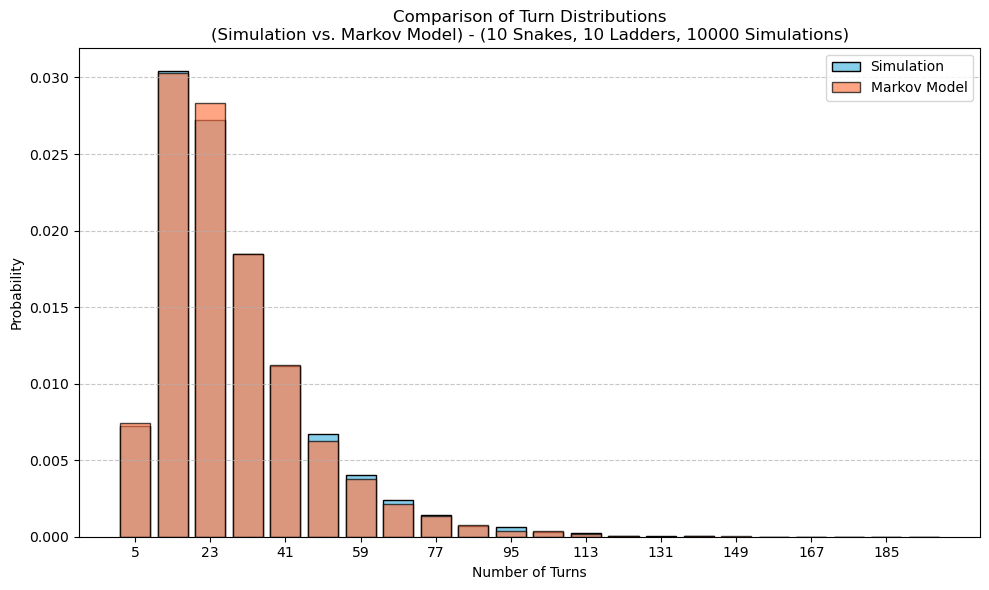

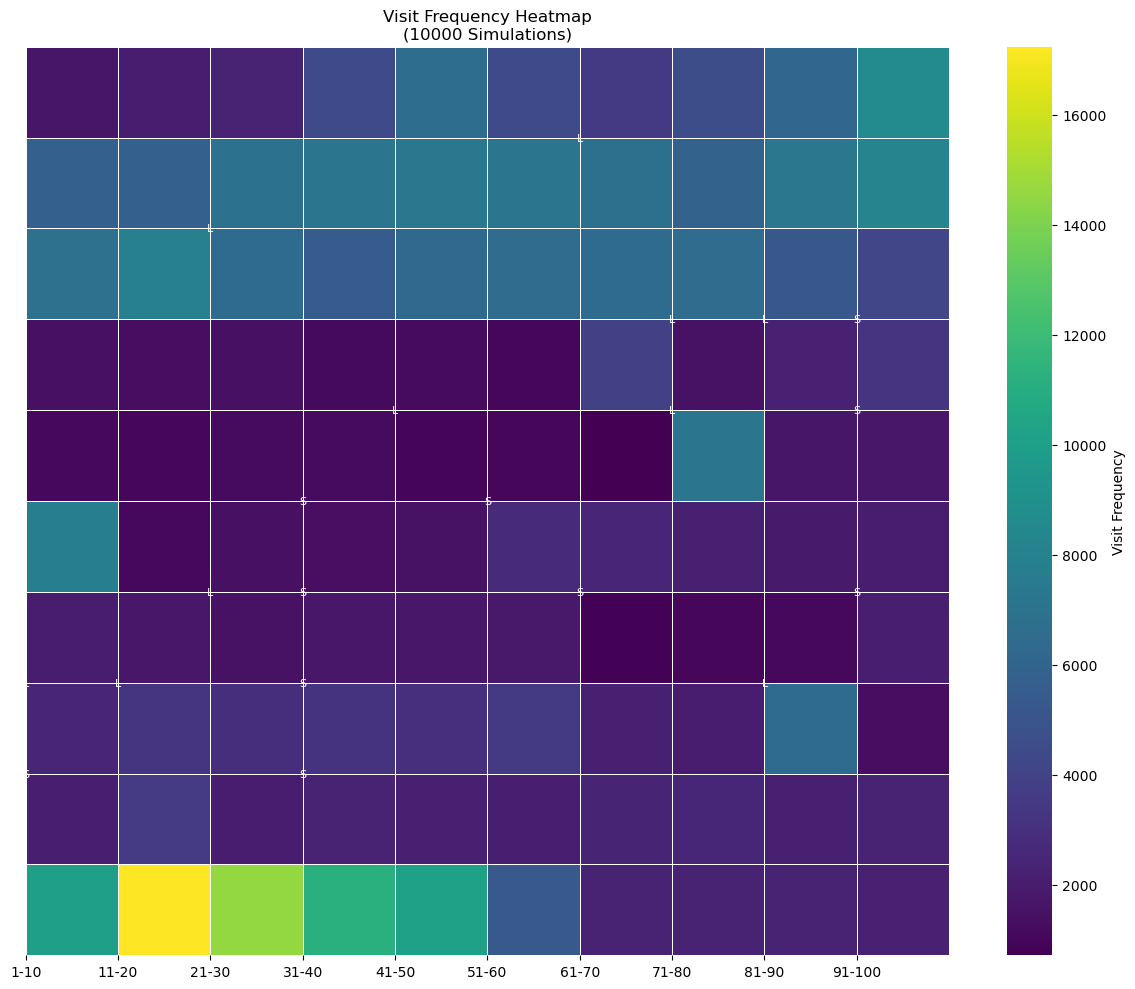

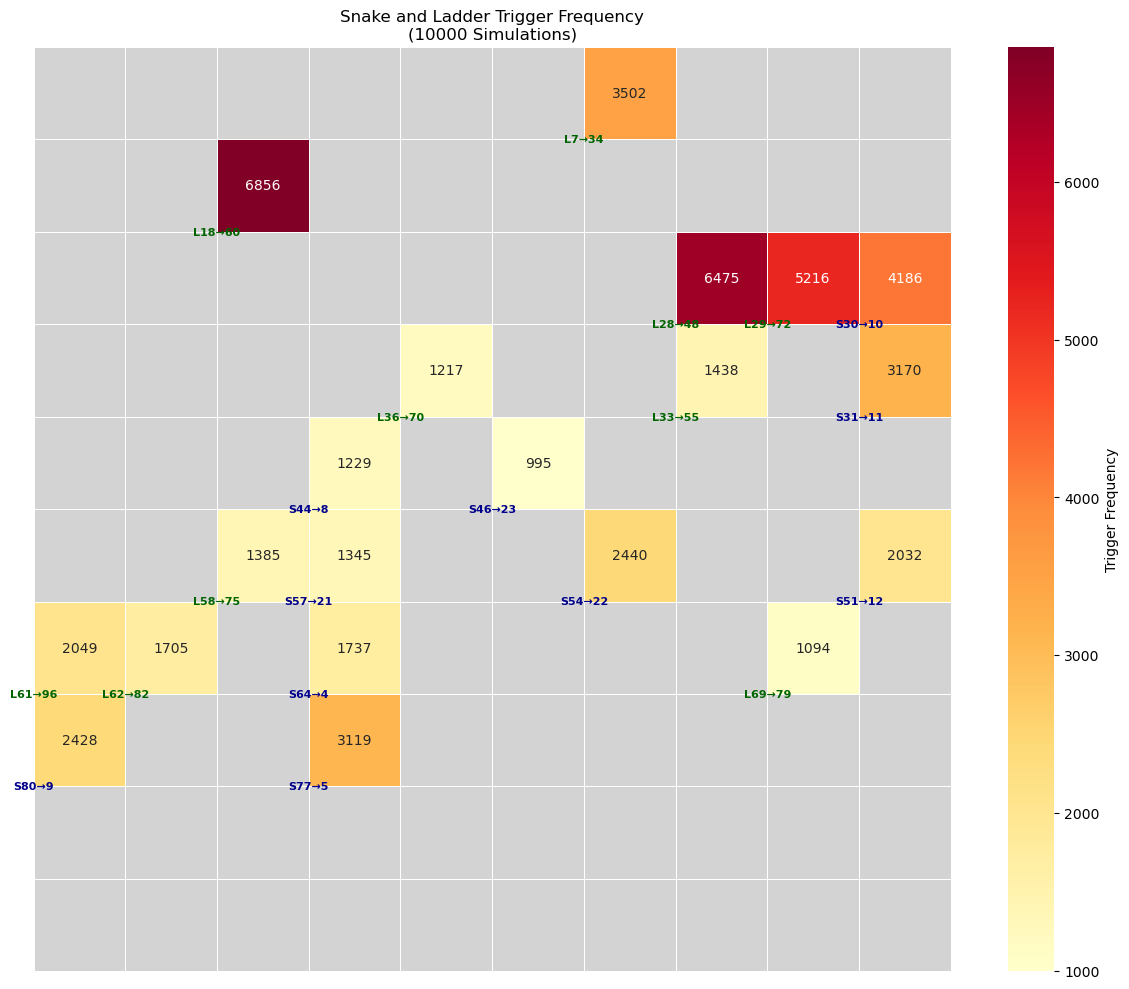

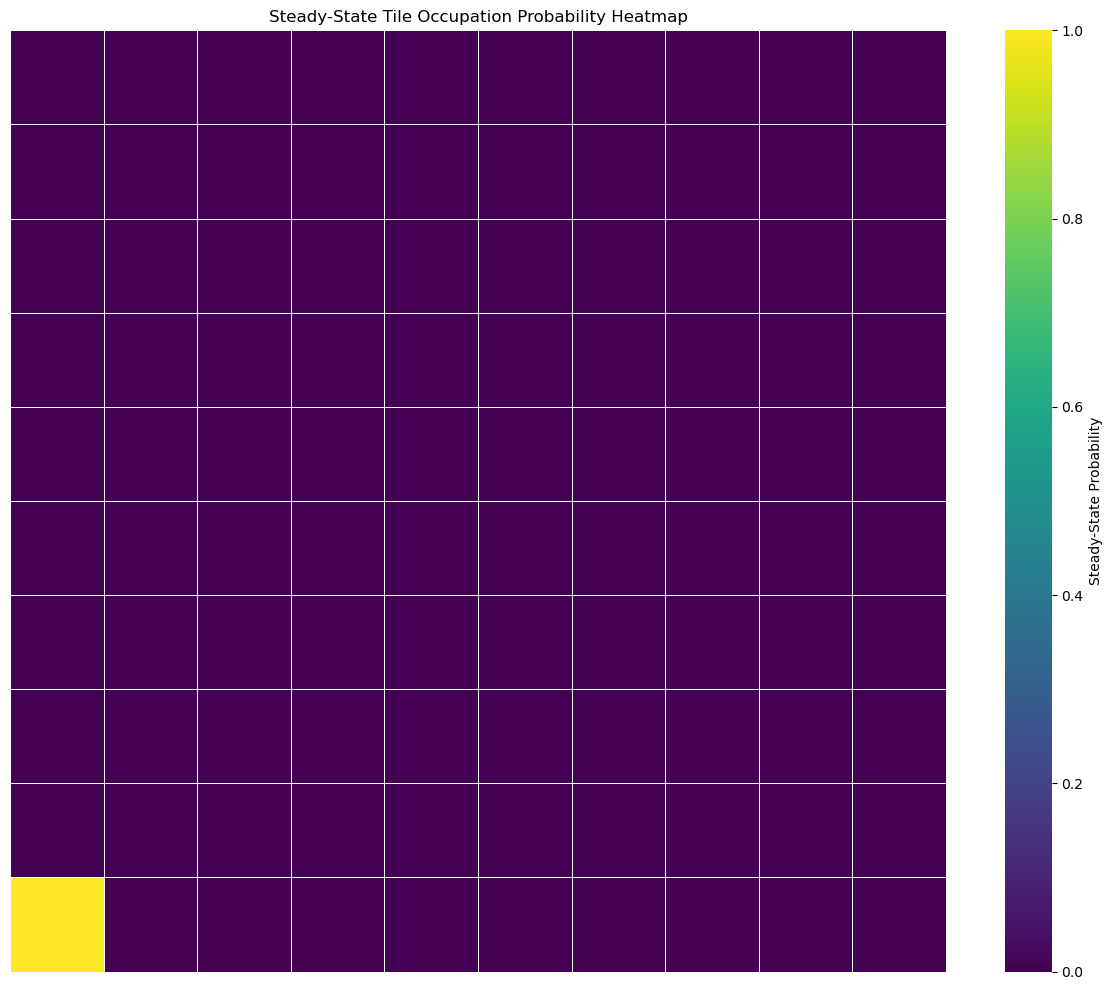

In [25]:
def run_analysis(board_size=100, num_snakes=10, num_ladders=10, num_simulations=10000, num_markov_simulations=10000, display_labeled_board=False):
    """
    Runs the complete analysis of the Snakes and Ladders game with optional labeled board display using sns.heatmap.
    """
    
    turn_counts_simulation = []
    all_positions_visited = []
    all_entity_triggers = []

    snakes, ladders = create_snakes_and_ladders(board_size, num_snakes, num_ladders)

    print("\nBoard Configuration:")
    print("Snakes:", {k: v for k, v in snakes.items()})
    print("Ladders:", {k: v for k, v in ladders.items()})

    if display_labeled_board:
        labeled_board_plt = plot_board_heatmap_representation(board_size, snakes, ladders) # Use heatmap plot
        labeled_board_plt.show()

    for _ in range(num_simulations):
        turns, positions, triggers = simulate_game(board_size, snakes, ladders,
                                                 record_positions=True,
                                                 record_entity_triggers=True)
        turn_counts_simulation.append(turns)
        all_positions_visited.append(positions)
        all_entity_triggers.append(triggers)

    avg_turns_simulation = sum(turn_counts_simulation) / num_simulations
    print(f"\nSimulation Results:")
    print(f"Average Turns (Simulation): {avg_turns_simulation:.2f}")
    print(f"Min Turns: {min(turn_counts_simulation)}")
    print(f"Max Turns: {max(turn_counts_simulation)}")

    transition_matrix = create_transition_matrix(board_size, snakes, ladders)
    try:
        expected_turns_markov = calculate_expected_turns_markov(transition_matrix, board_size, snakes, ladders)
        print(f"\nMarkov Analysis:")
        print(f"Expected Turns (Markov Model): {expected_turns_markov:.2f}")
    except np.linalg.LinAlgError:
        print("Markov analysis failed due to singular matrix")
        expected_turns_markov = None

    steady_state_distribution = calculate_steady_state_distribution(transition_matrix, board_size, snakes, ladders)
    
    # Simulate games from Markov model distribution
    turn_counts_markov = simulate_game_markov_distribution(transition_matrix, num_markov_simulations, board_size)

    plot_turn_distribution(turn_counts_simulation, turn_counts_markov, num_snakes, num_ladders, num_simulations) # Pass both turn count lists
    plot_board_heatmap(all_positions_visited, board_size, snakes, ladders, num_simulations)
    plot_entity_trigger_heatmap(all_entity_triggers, board_size, snakes, ladders, num_simulations)
    plot_steady_state_heatmap(steady_state_distribution, board_size, snakes, ladders)

if __name__ == "__main__":
    run_analysis(display_labeled_board=True, num_markov_simulations=10000)